# Insight Project --Birding Big Year--

In this project I intend to determine a way to see all the birds one can see on a single state, for a given time window.  For all those birdirers that want to get to the top 100 of their state on ebrid, this will be the perfect tool. The user will input the state, home address (or lat,lon), time window and birds that already have been seen*. This last one (*) is an optional thing.

In [1]:
import numpy as np
from datetime import datetime
import geopandas as gpd
import os
import struct
import pickle
import googlemaps
import pandas as pd
import psycopg2

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.cluster import DBSCAN

import SetCover
import DBScaner
import Definition

def save_fig(name):
    fig.savefig(name,dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')

%matplotlib inline

In [2]:
# import importlib
# importlib.reload(Definition)

# Here we go 2.0

In [3]:
# geocode_result = gmaps.geocode('{}'.format(userHomeBase))
# pickle.dump(geocode_result, open("./geocode_result_Madison.p", "wb" ))

In [4]:
geocode_result = pickle.load(open("./geocode_result_Madison.p", "rb" ))

In [5]:
geocode_result

[{'address_components': [{'long_name': 'Madison',
    'short_name': 'Madison',
    'types': ['locality', 'political']},
   {'long_name': 'Dane County',
    'short_name': 'Dane County',
    'types': ['administrative_area_level_2', 'political']},
   {'long_name': 'Wisconsin',
    'short_name': 'WI',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'United States',
    'short_name': 'US',
    'types': ['country', 'political']}],
  'formatted_address': 'Madison, WI, USA',
  'geometry': {'bounds': {'northeast': {'lat': 43.171916,
     'lng': -89.24645199999999},
    'southwest': {'lat': 42.998071, 'lng': -89.56638889999999}},
   'location': {'lat': 43.0730517, 'lng': -89.4012302},
   'location_type': 'APPROXIMATE',
   'viewport': {'northeast': {'lat': 43.171916, 'lng': -89.24645199999999},
    'southwest': {'lat': 42.998071, 'lng': -89.56638889999999}}},
  'place_id': 'ChIJ_xkgOm1TBogRmEFIurX8DE4',
  'types': ['locality', 'political']}]

In [6]:
state_long = geocode_result[0]['address_components'][2]['long_name']
state_short = geocode_result[0]['address_components'][2]['short_name']

In [7]:
lat = geocode_result[0]['geometry']['location']['lat']
lng = geocode_result[0]['geometry']['location']['lng']

### The ebird Data

The bird data has been trasnform to a Postgres SQL database.  This section of the code reads form this database to do the calculations. 

In [8]:
dbname = Definition.DBNAME
username = Definition.USERNAME
pswd = Definition.PSWD

In [9]:
## Now try the same queries, but in python!

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM test WHERE year = 2018;
"""
dfTrain = pd.read_sql_query(sql_query,con)

### Clustering using BDSCAN

BDSCAN is a density clustering that will tell where is popular for people to go birding (based on the desnity of hotsopts).  I will define a cluster as having atleast 3 point and with a maximum distance of 0.05degrees or about 5km.  With that I will optain where does each hotspot ('LOCALITY') belongs to. If '-1' they are not part of any cluster.

In [10]:
dfcluster, labels, n_clusters_ = DBScaner.cluster_selection(dfTrain)

In [11]:
dfCounts = DBScaner.cluster_center(dfcluster, dfTrain)

### Now some good plots

In [12]:
country = gpd.read_file('/Users/casanova/DocumentsHere/Insight/Project/gz_2010_us_040_00_5m.json')

In [13]:
unique_labels = set(labels)
colors = [plt.cm.viridis_r(each)
          for each in np.linspace(0, 1, len(unique_labels))]

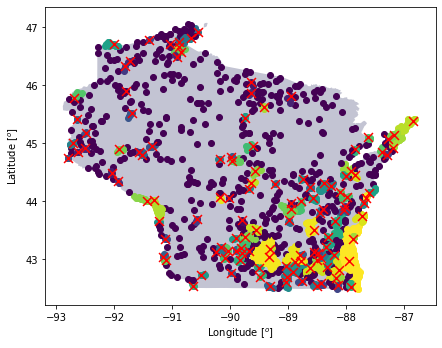

In [14]:
fig, ax = plt.subplots(1, figsize=(7,8))
base = country[country['NAME'].isin([state_long]) == True].plot(ax=ax, color='#3B3C6E', alpha = 0.3)
for i, clust in enumerate(labels):
    ax.scatter(np.array(dfcluster['longitude'])[i],np.array(dfcluster['latitude'])[i], color = colors[clust])
ax.scatter(dfCounts['longitude'],dfCounts['latitude'], marker = 'x', color = 'r', s=80)
ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')
# save_fig('/Users/casanova/DocumentsHere/Insight/{}-static.png'.format(state))
plt.show()

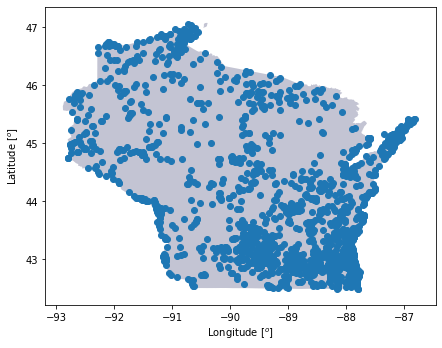

In [15]:
fig, ax = plt.subplots(1, figsize=(7,8))
base = country[country['NAME'].isin([state_long]) == True].plot(ax=ax, color='#3B3C6E', alpha = 0.3)
ax.scatter(dfcluster['longitude'],dfcluster['latitude'])
ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')

plt.show()
# save_fig('/Users/casanova/DocumentsHere/Insight/WI.png')

### Now the bird probability.

`dfbdscan` have the information of where each of the hotspots lay, in terms of their cluster.  Now in order to constuct a path is important to mask the probabilites of the of seeing a particular bird with T or F on a weekly basis.  This is critical in order to construc the sets.

In [16]:
dfProb = dfTrain.merge(dfcluster.filter(['locality','db_cluster']),
                            left_on='locality', right_on='locality', how = 'left').filter(['common_name','all_species_reported','year_week', 'db_cluster'])

In [17]:
nTime = 54
nLoc = n_clusters_
setMat = np.empty((nTime,nLoc), dtype=object)

In [18]:
for week in range(0,nTime):
    dfProbA = dfProb[dfProb['year_week']== week]
    dfProb1 = dfProbA.groupby(['common_name','db_cluster']).sum().filter(['all_species_reported']).reset_index()
    dfProb1.rename(columns = {'all_species_reported':'pos_obs'}, inplace=True)
    dfProb2 = dfProbA.groupby(['db_cluster']).sum().filter(['all_species_reported']).reset_index()
    dfProb2.rename(columns = {'all_species_reported':'tot_obs'}, inplace=True)
    dfProb3 = dfProb1.merge(dfProb2, left_on='db_cluster', right_on='db_cluster', how = 'left')
    dfProb3['pos_prob'] = dfProb3['pos_obs']/dfProb3['tot_obs']
    for loc in range(0,nLoc):
        dfWeek = dfProb3[dfProb3['db_cluster'] == loc]
        dfWeek['tf'] = list(map(lambda x: 0 if x < 0.02 else 1, dfWeek['pos_prob']))
        setMat[week,loc] = set(dfWeek[dfWeek['tf'] == 1]['common_name'].values)
        

<ipython-input-18-84fe6f760c4c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfWeek['tf'] = list(map(lambda x: 0 if x < 0.02 else 1, dfWeek['pos_prob']))


In [19]:
ToMakeUniverse = list(setMat.flatten())
Universe = set(e for s in ToMakeUniverse for e in s)

In [20]:
userInput = [lat,lng]

### Calculating google distances (dist matrix)

In [21]:
gmaps = googlemaps.Client(key='{}'.format(Definition.GOOGLEKEY))

In [22]:
coorHotspot = np.empty((n_clusters_+1, 2))
coorHotspot[:,0], coorHotspot[:,1] = dfCounts['longitude'],dfCounts['latitude']

In [23]:
'''
Choose between this and the cell below.  For test use the other one, it does not use google dist function.
'''

# distMat = np.empty((nTime,n_clusters_))
# countBreak = divmod(n_clusters_,100)

# for i in range(0,countBreak[0]):
#     distanceMatGmaps = gmaps.distance_matrix(origins = (userInput[0],userInput[1]), 
#                                          destinations=list(coorHotspot[100*i:100*(i+1)]),
#                                          mode = 'driving', units = 'metric')
#     for j in range(100*i,100*(i+1)):
#         jj = j - 100*i
#         try:
#             distMat[:,j] = distanceMatGmaps['rows'][0]['elements'][jj]['duration']['value']/3600
#         except KeyError:
#             distMat[:,j] = 100
        
# distanceMatGmaps = gmaps.distance_matrix(origins = (userInput[0],userInput[1]), 
#                                          destinations=list(coorHotspot[countBreak[0]*100:]),
#                                          mode = 'driving', units = 'metric')

# for j in range(countBreak[0]*100,countBreak[0]*100+countBreak[1]):
#     jj = j - countBreak[0]*100
#     try:
#         distMat[:,j] = distanceMatGmaps['rows'][0]['elements'][jj]['duration']['value']/3600
#     except KeyError:
#         distMat[:,j] = 100

'\nChoose between this and the cell below.  For test use the other one, it does not use google dist function.\n'

In [24]:
distMat = np.random.rand(nTime*n_clusters_).reshape((nTime,n_clusters_))

In [25]:
a, b = SetCover.set_cover_weighted_greedy(Universe, ToMakeUniverse,list(distMat.flatten()))

In [26]:
locListb = np.sort(b)

In [27]:
locMat = np.linspace(1,nTime*nLoc,nTime*nLoc).reshape(nTime,nLoc)

In [28]:
outList = []
for element in locListb:
    a,b = np.where(locMat == element)
    outList.append('On week {}, you need to be at location {}'.format(a[0],b[0]))

In [29]:
outList

['On week 2, you need to be at location 10',
 'On week 3, you need to be at location 60',
 'On week 3, you need to be at location 95',
 'On week 4, you need to be at location 72',
 'On week 5, you need to be at location 18',
 'On week 7, you need to be at location 3',
 'On week 7, you need to be at location 17',
 'On week 7, you need to be at location 45',
 'On week 7, you need to be at location 110',
 'On week 8, you need to be at location 61',
 'On week 8, you need to be at location 87',
 'On week 9, you need to be at location 110',
 'On week 9, you need to be at location 112',
 'On week 12, you need to be at location 6',
 'On week 12, you need to be at location 8',
 'On week 13, you need to be at location 33',
 'On week 14, you need to be at location 49',
 'On week 14, you need to be at location 104',
 'On week 15, you need to be at location 0',
 'On week 15, you need to be at location 4',
 'On week 15, you need to be at location 107',
 'On week 16, you need to be at location 2',
 '